## Fundamentos de Aprendizaje Automático

TP Final

Alejandro Said Núñez Selin

## Objetivo:

Se tienen 6 archivos de datos obtenidos utilizando un detector Cherenkov en agua

- 1 par de una fuente de Co60 (gamma) con su respectivo fondo
- 1 par de una fuente de AmBe con plomo (99% neutrones) con su respectivo fondo
- 1 par de la misma fuente AmBe sin plomo (neutrones + gamma) con su respectivo fondo

Es necesario medir un fondo aparte pues el detector no puede medir exclusiamente el espectro de la fuente, sino que los archivos donde se mide la fuente también contienen fondo.

Hasta ahora lo que se ha venido haciendo es hallar el espectro de carga de la fuente, hallar el espectro de carga del fondo y restarlos bin a bin.

#### Problema:

Con ese aproach simplemente obtendremos el espectro de carga de la fuente (o de alturas) pero no obtendremos los pulsos reales de la fuente pues están mezclados con el fondo.

Por tanto se plantean como objetivo (no digo que se vaya a cumplir a corto plazo):

-   Intentar sacar los pulsos que pertenecen solamente al tipo de radiación de la fuente de los archivos de medicion con fuente (estoy haciendo trampa acá, lo ideal sería diferenciar un gamma de la fuente de un gamma del fondo, pero no sé si eso es siquiera posible)
-   (Más a futuro) medir con una mayor cantidad de fuentes de diferentes tipos de radiación para caracterizar bien cada tipo de pulsos y poder del fondo natural decir cuáles pulsos pertenecen a cuál tipo de radiación
-   Por ahora me conformo con poder clasificar los pulsos gammas y de neutrones del resto del fondo de partículas (me vine arriba acá)

#### Disclaimer:

-   Los neutrones son partículas inestables fuera del núcleo atómico, por tanto se espera que hallan muy pocos neutrones en el fondo y por tanto sean más fáciles de clasificar

-   Los gammas en cambio son estables, y no solamente eso, sino que pueden ser producto de casi cualquier proceso atómico o nuclear, por lo que pueden venir de diferentes fuentes. Se intentarán clasificar pensando en que los gammas emitidos por la fuente son diferentes del resto de gammas del fondo (es el éxtasis cuando empiezas un nuevo proyecto, no me hagan caso)

## Vamos a ver qué encontramos y cómo lo intentamos solucionar en el camino!!

Intentemos primeramente cargar los datos y ver qué forma tienen los pulsos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import re
import os
import csv

Algunas funciones para reutilizar código

In [8]:
def sub_arr(arr):
    """
    Retorna una sub-array de 'arr' que contiene todos los elementos no negativos (pulso) 
    que se extienden hacia afuera desde el índice 8 hasta que se encuentran elementos negativos en ambos extremos.
    
    Parámetros:
    arr (list): Una lista de números enteros (evento).
    
    Retorna:
    list: Una sub-array de 'arr' con números enteros no negativos (pulso).
    """
    start, end = 8, 8
    while start >= 0 and arr[start] > 0:
        start -= 1
    while end < len(arr) and arr[end] > 0:
        end += 1
    if start == -1 and end == len(arr):
        return []
    if arr[start] < 0:
        start += 1
    if arr[end - 1] < 0:
        end -= 1
    return arr[start:end]

In [9]:
def subsegments(new_data):
    """
    Genera subsegmentos de datos a partir de segmentos proporcionados.

    Parámetros:
    new_data (list): Una lista de listas de números enteros (segmentos de datos).

    Retorna:
    list: Una lista de subsegmentos de datos.
    """
    return [sub_arr(segment) for segment in new_data if len(sub_arr(segment)) > 0]

In [10]:
def load_data(file_list):
    """
    Carga datos de una lista de archivos, calcula los máximos, las sumas y los pulsos promedio.

    Parámetros:
    file_list (list): Una lista de rutas de archivos a cargar.

    Retorna:
    tuple: Tres listas, una con los máximos, otra con las sumas y otra con los pulsos promedio para cada archivo.
    """
    all_max_per_file, all_sum_per_file, mean_pulses = [], [], []
    for file in file_list:
        data = np.loadtxt(file, np.int32, usecols=0)
        print(f'Longitud de {file}: {len(data)}')
        num_segments = len(data) // 32
        new_data = data[:num_segments * 32].reshape(-1, 32)
        mean_pulses.append(np.mean(new_data, axis=0))
        subsegment_data = subsegments(new_data)
        if subsegment_data:
            max_values = [np.max(subsegment) for subsegment in subsegment_data]
            all_max_per_file.append(max_values)
            sum_values = [np.sum(subsegment) for subsegment in subsegment_data]
            all_sum_per_file.append(sum_values)
    return all_max_per_file, all_sum_per_file, mean_pulses

In [11]:
def plot_histogram(data, bin_width, labels, title, x_label, y_label, log_scale=False, xlim=None):
    """
    Genera y muestra un histograma a partir de los datos proporcionados.

    Parámetros:
    data (list): Lista de listas con los datos a graficar.
    bin_width (int): Ancho del bin para el histograma.
    labels (list): Lista de etiquetas para las diferentes series de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    log_scale (bool): Si True, el eje y estará en escala logarítmica.
    xlim (tuple): Limites en el eje x.
    """
    for d, label in zip(data, labels):
        plt.hist(
            d,
            bins=np.arange(np.min(d), np.max(d), bin_width),
            histtype='step',
            label=label,
            linewidth=1.5
        )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    if log_scale:
        plt.yscale('log')
    if xlim:
        plt.xlim(xlim)
    plt.grid(True)
    plt.show()

In [12]:
def plot_mean_pulses(mean_pulses, labels, title, x_label, y_label):
    """
    Genera y muestra un gráfico de los pulsos promedio.

    Parámetros:
    mean_pulses (list): Lista de listas con los pulsos promedio.
    labels (list): Lista de etiquetas para las diferentes series de datos.
    title (str): Título del gráfico.
    x_label (str): Etiqueta del eje x.
    y_label (str): Etiqueta del eje y.
    """
    for pulse, label in zip(mean_pulses, labels):
        plt.plot(pulse, linewidth=1.5, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

In [13]:
def save_filtered_data(file_list, charge_range, output_dir):
    """
    Filtra y guarda los datos que se encuentran dentro del rango de carga especificado.

    Parámetros:
    file_list (list): Lista de archivos a procesar.
    charge_range (tuple): Rango de carga (min, max) para filtrar los datos.
    output_dir (str): Directorio donde se guardarán los archivos filtrados.
    """
    fuente_data, fondo_data = [], []
    fuente_file, fondo_file = file_list
    for file, data_list in zip([fuente_file, fondo_file], [fuente_data, fondo_data]):
        data = np.loadtxt(file, np.int32, usecols=0)
        num_segments = len(data) // 32
        segments = data[:num_segments * 32].reshape(-1, 32)
        subsegment_data = subsegments(segments)
        if subsegment_data:
            for index, subsegment in enumerate(subsegment_data):
                if charge_range[0] < np.sum(subsegment) < charge_range[1]:
                    data_list.append(segments[index])
    os.makedirs(output_dir, exist_ok=True)
    if fuente_data:
        np.savetxt(os.path.join(output_dir, "fuente_pulsos.csv"), np.array(fuente_data), delimiter=',', fmt='%d')
    if fondo_data:
        np.savetxt(os.path.join(output_dir, "fondo_pulsos.csv"), np.array(fondo_data), delimiter=',', fmt='%d')
    print(f"Datos guardados en {output_dir}")

Reemplazar en caso que la dirección de los archivos sea otra (Estos archivos no se van a subir, son muy pesados, y tampoco son necesarios luego de ser procesados)

In [14]:
file_list_Co = sorted(glob.glob('data/*Co*'))
file_list_AmBe_plomo = sorted(glob.glob('data/*10cm_plomo*'))
file_list_AmBe_noplomo = sorted(glob.glob('data/*10cm_noplomo*'))

Cálculo de las alturas, la carga y el pulso promedio, empecemos con el Co60

In [15]:
all_max_per_file_Co, all_sum_per_file_Co, mean_pulses_Co = load_data(file_list_Co)

Longitud de data/Co_1200V_170t1_5min.dat: 95742672
Longitud de data/fondo_Co_1200V_170t1_5min.dat: 59981350


Vamos a ver los histogramas de carga y los pulsos medios respectivamente de los espectros

Veamos todo el rango energético primero

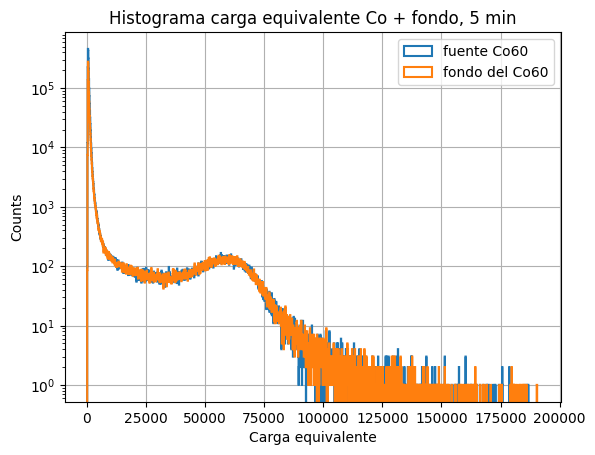

In [16]:
plot_histogram(
    all_sum_per_file_Co, 
    bin_width=100, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Histograma carga equivalente Co + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

La parte donde actúa la fuente parece ser la de baja energía

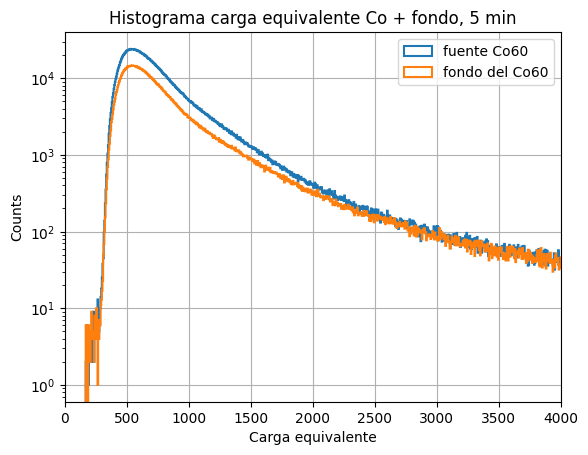

In [17]:
plot_histogram(
    all_sum_per_file_Co, 
    bin_width=5, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Histograma carga equivalente Co + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(0, 4000)
)

Veamos ahora los pulsos medios

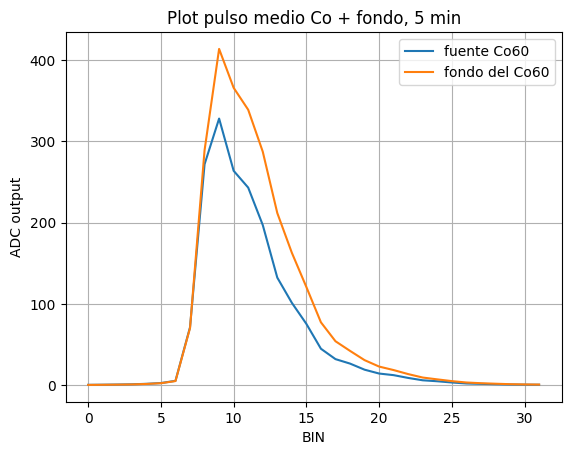

In [18]:
plot_mean_pulses(
    mean_pulses_Co, 
    labels=['fuente Co60', 'fondo del Co60'], 
    title='Plot pulso medio Co + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Los pulsos medios son muy similares, la forma de la señal parece ser mas menos la misma, pero los pulsos del fondo parecen más altos, lo más probable es que sea porque hay una mayor cantidad de cuentas en la parte de baja energía para la medición con fuente, eso afecta la estadística a la hora de hacer un promedio.

Anyways guardemos una parte del espectro del fondo y la fuente, de 500 a 600 en carga parece bien, hay bastante población de la fuente en ese rango energético

In [19]:
charge_thresholds_Co = (500, 600)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_Co, charge_thresholds_Co, "Co60")

Datos guardados en Co60


Libreremos memoria con lo que ya no se va a utilizar

In [20]:
del all_max_per_file_Co
del all_sum_per_file_Co

Vamos a por los neutrones ahora

In [21]:
file_list_AmBe_plomo = sorted(glob.glob('data/*10cm_plomo*'))
all_max_per_file_AmBe_plomo, all_sum_per_file_AmBe_plomo, mean_pulses_AmBe_plomo = load_data(file_list_AmBe_plomo)

Longitud de data/AmBe_30cm_10cm_plomo_1200V_650t1_5min.dat: 96712340
Longitud de data/fondo_10cm_plomo_1200V_170t1_5min.dat: 63388416


Nuevamente veamos todo el rango energético

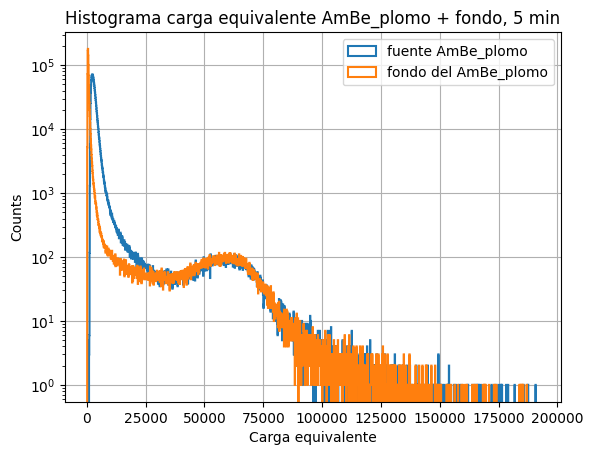

In [22]:
plot_histogram(
    all_sum_per_file_AmBe_plomo, 
    bin_width=100, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Histograma carga equivalente AmBe_plomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

Hagamos zoom donde actúa la fuente

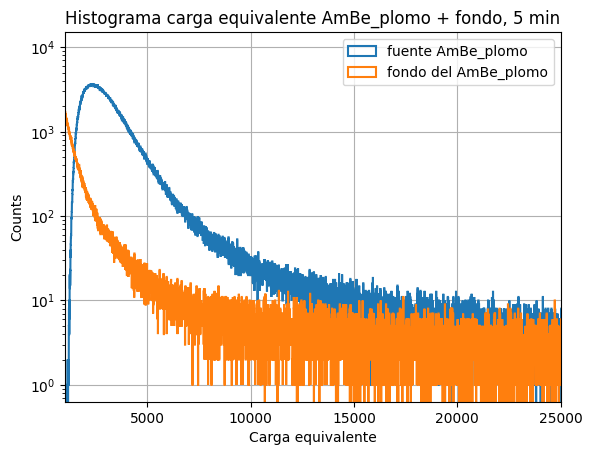

In [23]:
plot_histogram(
    all_sum_per_file_AmBe_plomo, 
    bin_width=5, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Histograma carga equivalente AmBe_plomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(1000, 25000)
)

Y el pulso medio

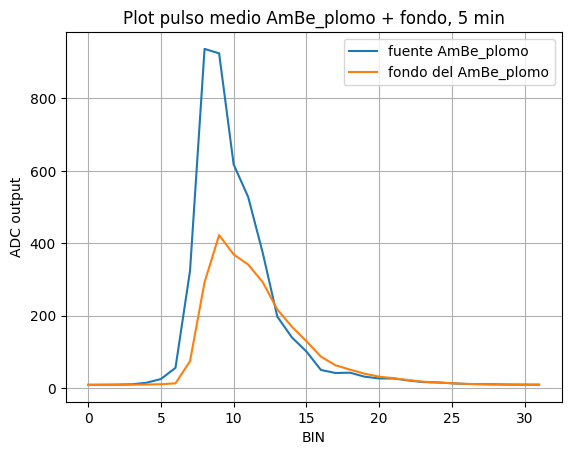

In [24]:
plot_mean_pulses(
    mean_pulses_AmBe_plomo, 
    labels=['fuente AmBe_plomo', 'fondo del AmBe_plomo'], 
    title='Plot pulso medio AmBe_plomo + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Los pulsos medios son muy diferentes en este caso, deben ser más clasificables los neutrones

Nuevamente guardemos un pedazo del espectro, de 4000 - 6000 parece bien

In [25]:
charge_thresholds_AmBe = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_plomo, charge_thresholds_AmBe, "AmBe_plomo")

Datos guardados en AmBe_plomo


In [26]:
del all_max_per_file_AmBe_plomo
del all_sum_per_file_AmBe_plomo

Veamos ahora la misma fuente, pero sin plomo. Al no estar presente el plomo, los gammas caractertísticos no son escudados, por lo q tendremos un espectro de gamma + neutrones + fondo

In [27]:
all_max_per_file_AmBe_noplomo, all_sum_per_file_AmBe_noplomo, mean_pulses_AmBe_noplomo = load_data(file_list_AmBe_noplomo)

Longitud de data/AmBe_30cm_10cm_noplomo_1200V_650t1_5min.dat: 102023726
Longitud de data/fondo_10cm_noplomo_1200V_170t1_5min.dat: 63388416


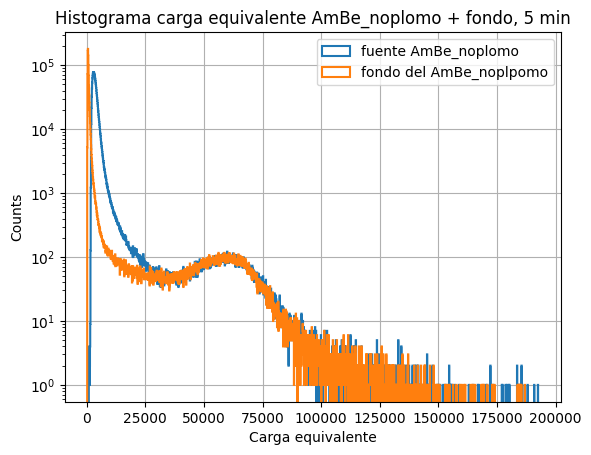

In [28]:
plot_histogram(
    all_sum_per_file_AmBe_noplomo, 
    bin_width=100, 
    labels=['fuente AmBe_noplomo', 'fondo del AmBe_noplpomo'], 
    title='Histograma carga equivalente AmBe_noplomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True
)

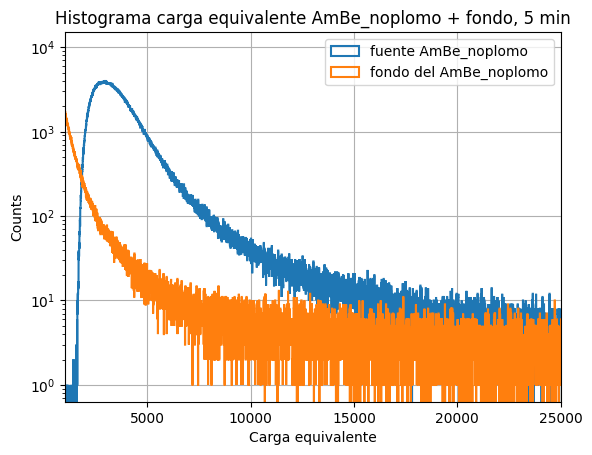

In [29]:
plot_histogram(
    all_sum_per_file_AmBe_noplomo, 
    bin_width=5, 
    labels=['fuente AmBe_noplomo', 'fondo del AmBe_noplomo'], 
    title='Histograma carga equivalente AmBe_noplomo + fondo, 5 min', 
    x_label='Carga equivalente', 
    y_label='Counts', 
    log_scale=True, 
    xlim=(1000, 25000)
)

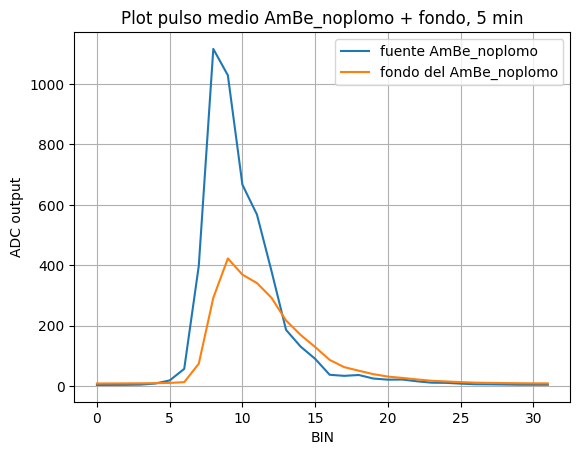

In [30]:
plot_mean_pulses(
    mean_pulses_AmBe_noplomo, 
    labels=['fuente AmBe_noplomo', 'fondo del AmBe_noplomo'], 
    title='Plot pulso medio AmBe_noplomo + fondo, 5 min', 
    x_label='BIN', 
    y_label='ADC output'
)

Igualmente estos pulsos parecen muy diferentes de los pulsos del fondo. Veamos una comparación entre los 4 tipos de pulsos

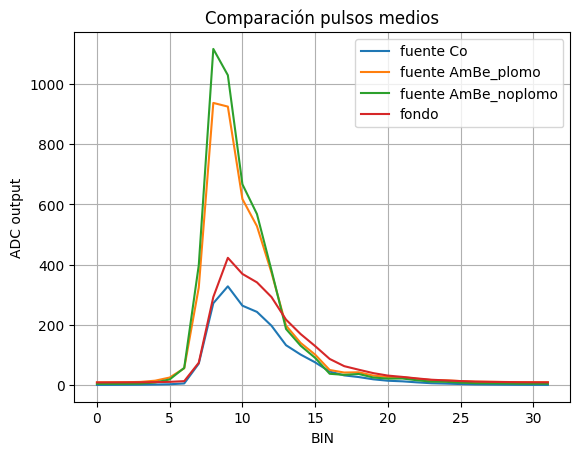

In [31]:
plt.plot(mean_pulses_Co[0], label = 'fuente Co')
plt.plot(mean_pulses_AmBe_plomo[0], label = 'fuente AmBe_plomo')
plt.plot(mean_pulses_AmBe_noplomo[0], label = 'fuente AmBe_noplomo')
plt.plot(mean_pulses_AmBe_noplomo[1], label = 'fondo')
plt.title('Comparación pulsos medios')
plt.xlabel('BIN')
plt.legend()
plt.grid()
plt.ylabel('ADC output')
plt.show()

-   El pulso medio de la fuente AmBe sin plomo parece una combinación entre el pulso del neutrón y los gammas, lo cual tiene sentido. La pregunta es si los pulsos tienen esa forma o es porque es un promedio

-   La forma del pulso de fondo de la fuente de neutrones se parece mucho al fondo de la parte de Co que a su vez se parece mucho a la propia fuente de Co60, todo parece indicar que en efecto hay muchos gammas en el fondo

In [32]:
charge_thresholds_AmBe_noplomo = (4000, 6000)  # Ajustar estos valores después de inspeccionar los histogramas
save_filtered_data(file_list_AmBe_noplomo, charge_thresholds_AmBe_noplomo, "AmBe_noplomo")

Datos guardados en AmBe_noplomo


In [33]:
del all_max_per_file_AmBe_noplomo
del all_sum_per_file_AmBe_noplomo

In [34]:
del mean_pulses_AmBe_noplomo
del mean_pulses_AmBe_plomo
del mean_pulses_Co

Estuve pensando cuántas dimensiones usar en el clasificador, primeramente pensé en 5, siendo estas, carga del pulso, altura, tiempo de subida (posición donde se alcanza el máximo), tiempo de bajada y ancho, pero luego caí en cuenta que como todos los pulsos tienen un ancho de 32 valores,
#### Podemos usar las 32 dimensiones!!
total una imagen de baja calidad es más que eso

Carguemos los csv y veamos los pulsos medios de solamente la parte energética que se está analizando en cada caso

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

Función para cargar datos y etiquetas

In [57]:
def cargar_datos_y_etiquetas(fuente_file, fondo_file):
    """
    Carga los datos y etiquetas desde los archivos fuente y fondo,
    y devuelve los datos combinados y las etiquetas correspondientes.

    Args:
        fuente_file (str): Ruta del archivo de datos fuente.
        fondo_file (str): Ruta del archivo de datos fondo.

    Returns:
        tuple: Un tuple que contiene los datos combinados y las etiquetas correspondientes.
            - data (ndarray): Un array numpy que contiene los datos combinados.
            - labels (ndarray): Un array numpy que contiene las etiquetas correspondientes.
    """
    fuente_pulsos = np.loadtxt(fuente_file, delimiter=',')
    fondo_pulsos = np.loadtxt(fondo_file, delimiter=',')
    fuente_labels = np.ones(fuente_pulsos.shape[0])
    fondo_labels = np.zeros(fondo_pulsos.shape[0])
    data = np.vstack((fuente_pulsos, fondo_pulsos))
    labels = np.concatenate((fuente_labels, fondo_labels))
    return data, labels

Cargar datos para AmBe_plomo (neutrones)

In [58]:
fuente_file_AmBe_plomo = 'AmBe_plomo/fuente_pulsos.csv'
fondo_file_AmBe_plomo = 'AmBe_plomo/fondo_pulsos.csv'

In [59]:
data_AmBe_plomo, labels_AmBe_plomo = cargar_datos_y_etiquetas(fuente_file_AmBe_plomo, fondo_file_AmBe_plomo)

Dividir en conjuntos de entrenamiento y prueba

In [60]:
X_train_AmBe_plomo, X_test_AmBe_plomo, y_train_AmBe_plomo, y_test_AmBe_plomo = train_test_split(data_AmBe_plomo, labels_AmBe_plomo, test_size=0.3, random_state=42)

Si las clases están desbalanceadas, el modelo puede inclinarse hacia la clase mayoritaria. Usaremos técnicas de balanceo como submuestreo de la clase mayoritaria o sobremuestreo de la clase minoritaria

In [61]:
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_AmBe_plomo, y_train_AmBe_plomo)

Entrenar el modelo con losdatos balanceados, empecemos con un Random Forest

In [62]:
clf_AmBe_plomo = RandomForestClassifier(n_estimators=100, random_state=42)
clf_AmBe_plomo.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

Veamos el rendimento del modelo con el conjunto de prueba

In [63]:
y_pred_AmBe_plomo = clf_AmBe_plomo.predict(X_test_AmBe_plomo)
print("Accuracy:", accuracy_score(y_test_AmBe_plomo, y_pred_AmBe_plomo))
print("Confusion Matrix:\n", confusion_matrix(y_test_AmBe_plomo, y_pred_AmBe_plomo))
print("Classification Report:\n", classification_report(y_test_AmBe_plomo, y_pred_AmBe_plomo))

Accuracy: 0.9973056900173531
Confusion Matrix:
 [[ 2076    70]
 [  107 63441]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2146
         1.0       1.00      1.00      1.00     63548

    accuracy                           1.00     65694
   macro avg       0.97      0.98      0.98     65694
weighted avg       1.00      1.00      1.00     65694



Parece casi perfecto! Vamos a intentar clasificar neutrones de fondo

In [64]:
# Pulsos originales de fuente + fondo en fuente_pulsos.csv
fuente_real_AmBe_plomo = np.loadtxt(fuente_file_AmBe_plomo, delimiter=',')

# Pasandole el clasificador entrenado
predictions_fuente = clf_AmBe_plomo.predict(fuente_real_AmBe_plomo)

# Separar los pulsos predichos como fuente y como fondo de los pulsos originales de fuente_pulsos.csv
fuente_predicha_AmBe_plomo = fuente_real_AmBe_plomo[predictions_fuente == 1]
fondo_predicho_AmBe_plomo = fuente_real_AmBe_plomo[predictions_fuente == 0]

Veamos la forma de los pulsos

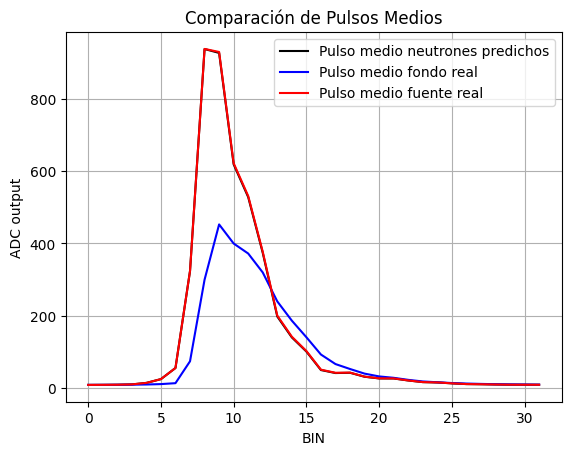

In [65]:
fondo_real_AmBe_plomo = np.loadtxt(fondo_file_AmBe_plomo, delimiter=',')

# Calcular los pulsos medios
pulso_medio_fuente_predicha_AmBe_plomo = np.mean(fuente_predicha_AmBe_plomo, axis=0)
pulso_medio_fondo_real_AmBe_plomo = np.mean(fondo_real_AmBe_plomo, axis=0)
pulso_medio_fuente_real_AmBe_plomo = np.mean(fuente_real_AmBe_plomo, axis=0)

# Graficar los pulsos medios
plt.plot(pulso_medio_fuente_predicha_AmBe_plomo, label='Pulso medio neutrones predichos', color = 'black')
plt.plot(pulso_medio_fondo_real_AmBe_plomo, label='Pulso medio fondo real', color = 'blue')
plt.plot(pulso_medio_fuente_real_AmBe_plomo, label='Pulso medio fuente real', color = 'red')
plt.title('Comparación de Pulsos Medios')
plt.xlabel('BIN')
plt.ylabel('ADC output')
plt.legend()
plt.grid(True)
plt.show()

Con los pulsos medios no se puede apreciar bien, veamos las cargas reales y las predichas

In [69]:
print('Carga fuente real AmBe:', fuente_real_AmBe_plomo.sum())

print('Carga neutrones predichos:', fuente_predicha_AmBe_plomo.sum())
print('Carga no neutrones predichos', fondo_predicho_AmBe_plomo.sum())

Carga fuente real AmBe: 985038694.0
Carga neutrones predichos: 980142111.0
Carga no neutrones predichos 4896583.0


Veamos que no se identificó como neutrones en el espectro de la fuente AmBe_plomo

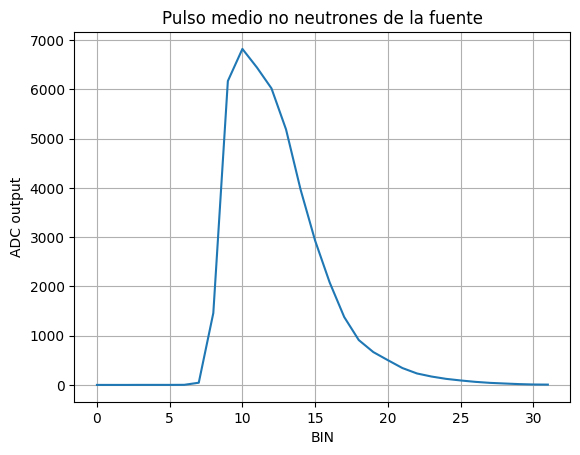

In [74]:
pulso_medio_fondo_predicho_AmBe_plomo = np.mean(fondo_predicho_AmBe_plomo, axis=0)

plt.plot(pulso_medio_fondo_predicho_AmBe_plomo)
plt.title('Pulso medio no neutrones de la fuente')
plt.xlabel('BIN')
plt.ylabel('ADC output')
plt.grid(True)
plt.show()

Parecen gammas muy energéticos. En realidad tiene sentido, el plomo escuda el 99% de los gammas, lo cual es más que suficiente en las aplicaciones prácticas.

Veamos que sucede con la fuente de Co60, esto es una fuente gamma con 2 picos energéticos, uno en 1.17MeV y el otro 1.33MeV, el problema es que nuestro detector no es un espectrómetro, no se van a poder observar 2 picos, sino todo un continuo, siendo el último bin donde corta con el fondo el equivalente a esos 1.33MeV (cosas de ángulos de Compton)

El resumen es que probablemente no halla algo así como "gammas de forma característica"

Anyways hagamos el mismo procedimiento y veamos qué obtenemos

In [75]:
fuente_file_Co60 = 'Co60/fuente_pulsos.csv'
fondo_file_Co60 = 'Co60/fondo_pulsos.csv'

In [76]:
data_Co60, labels_Co60 = cargar_datos_y_etiquetas(fuente_file_Co60, fondo_file_Co60)

In [77]:
X_train_Co60, X_test_Co60, y_train_Co60, y_test_Co60 = train_test_split(data_Co60, labels_Co60, test_size=0.3, random_state=42)

In [78]:
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_Co60, y_train_Co60)

In [79]:
clf_Co60 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_Co60.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [80]:
y_pred_Co60 = clf_Co60.predict(X_test_Co60)
print("Accuracy:", accuracy_score(y_test_Co60, y_pred_Co60))
print("Confusion Matrix:\n", confusion_matrix(y_test_Co60, y_pred_Co60))
print("Classification Report:\n", classification_report(y_test_Co60, y_pred_Co60))

Accuracy: 0.6049145709349203
Confusion Matrix:
 [[  9729  75226]
 [ 13268 125764]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.42      0.11      0.18     84955
         1.0       0.63      0.90      0.74    139032

    accuracy                           0.60    223987
   macro avg       0.52      0.51      0.46    223987
weighted avg       0.55      0.60      0.53    223987



#### :(

In [81]:
# Pulsos originales de fuente + fondo en fuente_pulsos.csv
fuente_real_Co60 = np.loadtxt(fuente_file_Co60, delimiter=',')

# Pasandole el clasificador entrenado
predictions_fuente = clf_Co60.predict(fuente_real_Co60)

# Separar los pulsos predichos como fuente y como fondo de los pulsos originales de fuente_pulsos.csv
fuente_predicha_Co60 = fuente_real_Co60[predictions_fuente == 1]
fondo_predicho_Co60 = fuente_real_Co60[predictions_fuente == 0]

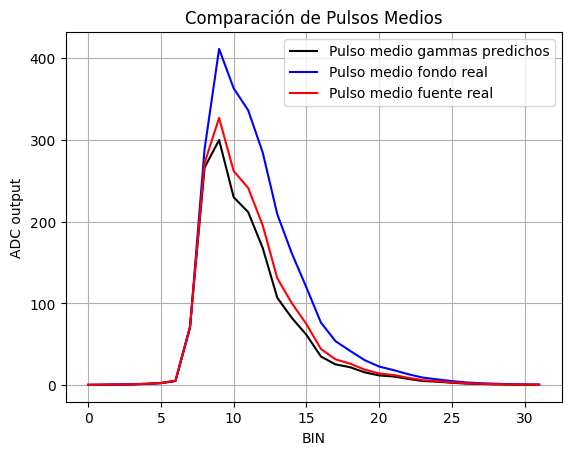

In [82]:
fondo_real_Co60 = np.loadtxt(fondo_file_Co60, delimiter=',')

# Calcular los pulsos medios
pulso_medio_fuente_predicha_Co60 = np.mean(fuente_predicha_Co60, axis=0)
pulso_medio_fondo_real_Co60 = np.mean(fondo_real_Co60, axis=0)
pulso_medio_fuente_real_Co60 = np.mean(fuente_real_Co60, axis=0)

# Graficar los pulsos medios
plt.plot(pulso_medio_fuente_predicha_Co60, label='Pulso medio gammas predichos', color = 'black')
plt.plot(pulso_medio_fondo_real_Co60, label='Pulso medio fondo real', color = 'blue')
plt.plot(pulso_medio_fuente_real_Co60, label='Pulso medio fuente real', color = 'red')
plt.title('Comparación de Pulsos Medios')
plt.xlabel('BIN')
plt.ylabel('ADC output')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
print('Carga fuente real AmBe:', fuente_real_Co60.sum())

print('Carga gammas predichos:', fuente_predicha_Co60.sum())
print('Carga no gammas predichos', fondo_predicho_Co60.sum())

Carga fuente real AmBe: 867287444.0
Carga gammas predichos: 748683698.0
Carga no gammas predichos 118603746.0


Intentemos ver qué se clasificó como "no gammas de la fuente"

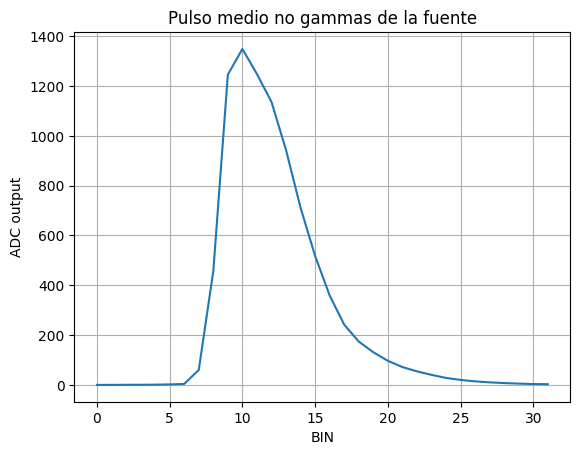

In [85]:
pulso_medio_fondo_predicho_Co60 = np.mean(fondo_predicho_Co60, axis=0)

plt.plot(pulso_medio_fondo_predicho_Co60)
plt.title('Pulso medio no gammas de la fuente')
plt.xlabel('BIN')
plt.ylabel('ADC output')
plt.grid(True)
plt.show()

Se parecen mucho a los "no neutrones" que sacamos de la fuente de AmBe_plomo🤔